In [1]:
import torch
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import nn
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision.utils import make_grid

In [2]:
MODEL_PATH = "/home/alan/Documents/Cloud_Detection/neural network/c_unet_1649683131.7209947.pth"
r"""
RED_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\Dataset\Full dataset\95red_filter\\"
GREEN_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\Dataset\Full dataset\95green_filter\\"
BLUE_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\Dataset\Full dataset\95blue_filter\\"
NIR_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\Dataset\Full dataset\95nir_filter\\"
GT_PATH = r"C:\Users\hdmqu\Documents\LUX Aerobot\Dataset\Full dataset\95gt_filter\\"
"""

RED_PATH = "/home/alan/Documents/cloud_detection_data/95Cloud/95red/"
GREEN_PATH = "/home/alan/Documents/cloud_detection_data/95Cloud/95green/"
BLUE_PATH = "/home/alan/Documents/cloud_detection_data/95Cloud/95blue/"
NIR_PATH = "/home/alan/Documents/cloud_detection_data/95Cloud/95nir/"
GT_PATH = "/home/alan/Documents/cloud_detection_data/95Cloud/95gt/"


r_dir = Path(RED_PATH)

Percentage of cloud

In [8]:
#   0%      1 - 30%    30 - 70%    70 - 100%
no_cloud, less_cloud, more_cloud, full_cloud = [], [], [], []

low_threshold = 384*384 * 0.3
high_threshold = 384*384 * 0.7

u = os.listdir(GT_PATH)

for file in u[int(len(u)/2):]:
    img = cv2.imread(GT_PATH + file)
    
    occurrences = np.count_nonzero(img[:, :, 0] == 255)

    if occurrences == 0:
        no_cloud.append(file)
        continue
    elif occurrences < low_threshold:
        less_cloud.append(file)
        continue
    elif occurrences < high_threshold:
        more_cloud.append(file)
    else:
        full_cloud.append(file)

print("No cloud images:\t", len(no_cloud))
print("Less cloud images:\t", len(less_cloud))
print("More cloud images:\t", len(more_cloud))
print("Full cloud images:\t", len(full_cloud))
print("Total images:\t\t", int(len(os.listdir(GT_PATH))/2)+1)

No cloud images:	 2021
Less cloud images:	 1960
More cloud images:	 1189
Full cloud images:	 3004
Total images:		 8174


In [9]:
def to_path(list):
    for i in range(len(list)):
        list[i] = RED_PATH + list[i].replace("gt", "red")
    return list

In [10]:
no_cloud_list = to_path(no_cloud)
less_cloud_list = to_path(less_cloud)
more_cloud_list = to_path(more_cloud)
full_cloud_list = to_path(full_cloud)

In [11]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, file_list):
        super().__init__()
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in file_list if not os.path.isdir(f)]
        
    def combine_files(self, r_file: Path, g_dir, b_dir, nir_dir, gt_dir):
        files = {
            'red': r_file, 
            'green': r_file.replace('red', 'green'),
            'blue': r_file.replace('red', 'blue'), 
            'nir': r_file.replace('red', 'nir'),
            'gt': r_file.replace('red', 'gt')
        }
        return files
                                       
    def __len__(self):
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):
        raw_rgb = np.stack([
            np.array(Image.open(self.files[idx]['red'])),
            np.array(Image.open(self.files[idx]['green'])),
            np.array(Image.open(self.files[idx]['blue'])),
        ], axis=2)
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max) # normalized


    def open_mask(self, idx, add_dims=False):
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        x = torch.tensor(self.open_as_array(idx, invert=True, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.long)
        return x, y
    
    def __repr__(self):
        return f'Dataset class with {self.__len__()} files'

In [12]:
no_cloud_data =  CloudDataset(RED_PATH, GREEN_PATH, BLUE_PATH, NIR_PATH, GT_PATH, no_cloud_list)
less_cloud_data =  CloudDataset(RED_PATH, GREEN_PATH, BLUE_PATH, NIR_PATH, GT_PATH, less_cloud_list)
more_cloud_data =  CloudDataset(RED_PATH, GREEN_PATH, BLUE_PATH, NIR_PATH, GT_PATH, more_cloud_list)
full_cloud_data =  CloudDataset(RED_PATH, GREEN_PATH, BLUE_PATH, NIR_PATH, GT_PATH, full_cloud_list)

print(no_cloud_data)
print(less_cloud_data)
print(more_cloud_data)
print(full_cloud_data)

Dataset class with 2021 files
Dataset class with 1960 files
Dataset class with 1189 files
Dataset class with 3004 files


In [13]:
# Single input example
x, y = no_cloud_data[0]
print(f'Image: {x.shape}')
print(f'Mask: {y.shape}')

Image: torch.Size([4, 384, 384])
Mask: torch.Size([384, 384])


In [14]:
class depthwiseSeparableConv(nn.Module):
    def __init__(self, nin, nout):
        super(depthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [15]:
class C_UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = self.contract_block(in_channels, 32)
        self.conv2 = self.contract_block(32, 64)
        self.conv3 = self.contract_block(64, 128)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64, 32, 3, 1)
        self.upconv1 = self.expand_block(32, out_channels, 3, 1)

        self.out = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 1),
            nn.Sigmoid()
        )


    def __call__(self, x):
        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(upconv3)
        upconv1 = self.upconv1(upconv2)

        out = self.out(upconv1)

        return out


    def contract_block(self, in_channels, out_channels):
        contract = nn.Sequential(
            depthwiseSeparableConv(in_channels, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        return contract


    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
        )
        return expand

In [16]:
def my_collate(batch):
    batch = list(filter (lambda x:torch.sum(x[0]).item() != 0, batch))
    if len(batch) == 0:
        print("DOOOOO")
    return torch.utils.data.dataloader.default_collate(batch)

# Constants
BATCH_SIZE = 32
NUM_WORKER = 0
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {DEVICE} device.")

no_cloud_loader = DataLoader(no_cloud_data, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, collate_fn=my_collate)
less_cloud_loader = DataLoader(less_cloud_data, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, collate_fn=my_collate)
more_cloud_loader = DataLoader(more_cloud_data, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, collate_fn=my_collate)
full_cloud_loader = DataLoader(full_cloud_data, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, collate_fn=my_collate)

Using cpu device.


In [17]:
c_unet = C_UNet(4, 2)
c_unet.to(DEVICE)

c_unet.load_state_dict(torch.load(MODEL_PATH))
c_unet.eval()

C_UNet(
  (conv1): Sequential(
    (0): depthwiseSeparableConv(
      (depthwise): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4)
      (pointwise): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): depthwiseSeparableConv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): depthwiseSeparableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [20]:
import torchmetrics

def get_accuracy(data_loader, model):
    acc, rec, pre, f1 = [], [], [], []

    accuracy = torchmetrics.Accuracy()
    recall = torchmetrics.Recall()
    precision = torchmetrics.Precision()
    f1_score = torchmetrics.F1Score()


    for images, targets in tqdm(data_loader):
        with torch.no_grad():
            
            # Get predictions
            images = images.to(DEVICE).to(torch.float32)
            targets = targets.to(DEVICE)
            predictions = model(images)[:, 1, :, :].to(torch.float32)

            acc.append(accuracy(predictions, targets))
            rec.append(recall(predictions, targets))
            pre.append(precision(predictions, targets))
            f1.append(f1_score(predictions, targets))

    #return round(np.mean(acc), 4), round(np.mean(rec)), round(np.mean(pre), 4), round(np.mean(f1), 4)
    return np.mean(acc), np.mean(rec), np.mean(pre), np.mean(f1)

In [21]:
no_acc, no_rec, no_pre, no_f1 = get_accuracy(no_cloud_loader, c_unet)
less_acc, less_rec, less_pre, less_f1 = get_accuracy(less_cloud_loader, c_unet)
more_acc, more_rec, more_pre, more_f1 = get_accuracy(more_cloud_loader, c_unet)
full_acc, full_rec, full_pre, full_f1 = get_accuracy(full_cloud_loader, c_unet)

100%|██████████| 94/94 [07:08<00:00,  4.56s/it]


In [22]:
print("\t\tAccuracy\tRecall\t\tPrecision\tF1")
print(f"No cloud:\t{no_acc}\t{no_rec}\t{no_pre}\t{no_f1}")
print(f"Less cloud:\t{less_acc}\t{less_rec}\t{less_pre}\t{less_f1}")
print(f"More cloud:\t{more_acc}\t{more_rec}\t{more_pre}\t{more_f1}")
print(f"Full cloud:\t{full_acc}\t{full_rec}\t{full_pre}\t{full_f1}")

		Accuracy	Recall		Precision	F1
No cloud:	0.9886711835861206	0.0	0.0	0.0
Less cloud:	0.9388284087181091	0.494551420211792	0.6713060736656189	0.5602937340736389
More cloud:	0.7777925729751587	0.6157420873641968	0.9061927795410156	0.7251826524734497
Full cloud:	0.7434255480766296	0.7383068203926086	0.9904526472091675	0.8444265127182007


Cloud thickness

In [23]:
thin_cloud, thick_cloud = [], []

thickness_threshold = (0.46875, 0.46875, 0.46875, 0.46875)

for i in range(len(full_cloud_data)):

    x, y = full_cloud_data[i]
    out = cv2.inRange(torch.permute(x, (1, 2, 0)).numpy(), thickness_threshold, (1, 1, 1, 1))

    try:
        IoU = np.sum(np.logical_and(out, y.numpy())) / np.sum(np.logical_or(out, y.numpy()))
    except ZeroDivisionError:
        thin_cloud.append(full_cloud_list[i])
        continue

    if IoU > 0.5:
        thick_cloud.append(full_cloud_list[i])
    else:
        thin_cloud.append(full_cloud_list[i])

In [24]:
print(len(thin_cloud))
print(len(thick_cloud))

2890
114


In [25]:
thin_cloud_data =  CloudDataset(RED_PATH, GREEN_PATH, BLUE_PATH, NIR_PATH, GT_PATH, thin_cloud)
thick_cloud_data =  CloudDataset(RED_PATH, GREEN_PATH, BLUE_PATH, NIR_PATH, GT_PATH, thick_cloud)

In [26]:
thin_cloud_loader = DataLoader(thin_cloud_data, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, collate_fn=my_collate)
thick_cloud_loader = DataLoader(thick_cloud_data, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER, collate_fn=my_collate)

In [27]:
thin_acc, thin_rec, thin_pre, thin_f1 = get_accuracy(thin_cloud_loader, c_unet)
thick_acc, thick_rec, thick_pre, thick_f1 = get_accuracy(thick_cloud_loader, c_unet)

100%|██████████| 4/4 [00:17<00:00,  4.33s/it]


In [28]:
print("\t\tAccuracy\tRecall\t\tPrecision\tF1")
print(f"Thin cloud:\t{thin_acc}\t{thin_rec}\t{thin_pre}\t{thin_f1}")
print(f"Thick cloud:\t{thick_acc}\t{thick_rec}\t{thick_pre}\t{thick_f1}")

		Accuracy	Recall		Precision	F1
Thin cloud:	0.7344057559967041	0.7286624312400818	0.9899296760559082	0.8375867009162903
Thick cloud:	0.9947988390922546	0.9960440397262573	0.9986413717269897	0.9973385334014893


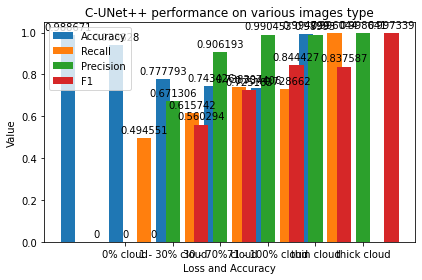

In [29]:
# data to plot
acc_list = [no_acc, less_acc, more_acc, full_acc, thin_acc, thick_acc]
rec_list = [no_rec, less_rec, more_rec, full_rec, thin_rec, thick_rec]
pre_list = [no_pre, less_pre, more_pre, full_pre, thin_pre, thick_pre]
f1_list = [no_f1, less_f1, more_f1, full_f1, thin_f1, thick_f1]

name_list = ("0% cloud", 
             "1 - 30% cloud", 
             "30 - 70% cloud",
             "71 - 100% cloud",
             "thin cloud",
             "thick cloud")

n_groups = len(name_list)

# create plot
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (30, 16)
index = np.arange(n_groups)
bar_width = 0.6

rects1 = plt.bar(index + bar_width*-2, acc_list, bar_width/2, label="Accuracy")
rects2 = plt.bar(index + bar_width*-1, rec_list, bar_width/2, label="Recall")
rects3 = plt.bar(index + bar_width*0, pre_list, bar_width/2, label="Precision")
rects4 = plt.bar(index + bar_width*1, f1_list, bar_width/2, label="F1")

plt.xlabel("Loss and Accuracy")
plt.ylabel("Value")
plt.title('C-UNet++ performance on various images type')
plt.xticks(index, name_list)
plt.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)

plt.tight_layout()
plt.savefig("/home/alan/Documents/Cloud_Detection/Performance bar chart (hinge loss).png", bbox_inches="tight")
plt.show()

In [30]:
name = ["", "No Cloud", "Less Cloud", "More Cloud", "Full Cloud", "Thin Cloud", "Thick Cloud"]
s = np.asarray([ name, 
                 ["Accuracy"] + acc_list, 
                 ["Recall"] + rec_list, 
                 ["Precision"] + pre_list, 
                 ["F1"] + f1_list ])
np.savetxt("/home/alan/Documents/import.csv", s, delimiter=",", fmt='%s')